In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4f4f5d680d0aa3792399e16167938defe76bcd06233e9e5eb5132cd32611be9a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# **PCA**

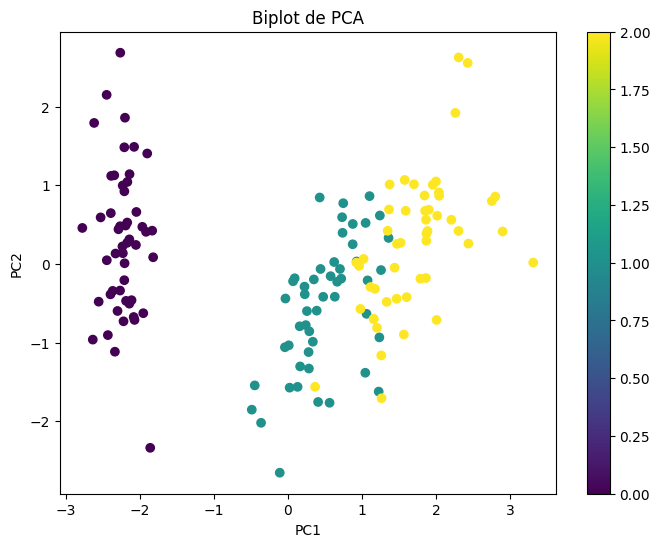

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

# Cargar el dataset de ejemplo
iris = load_iris()
X = iris.data
y = iris.target

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Crear y entrenar el modelo PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
explained_variance = pca.explained_variance_ratio_

# Gráfico de Codo
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(explained_variance) + 1)), y=explained_variance, mode='lines+markers'))
fig.update_layout(title='Gráfico de Codo',
                  xaxis_title='Componentes Principales',
                  yaxis_title='Varianza Explicada',
                  showlegend=False)
fig.show()

# Biplot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot de PCA')
plt.colorbar()
plt.show()

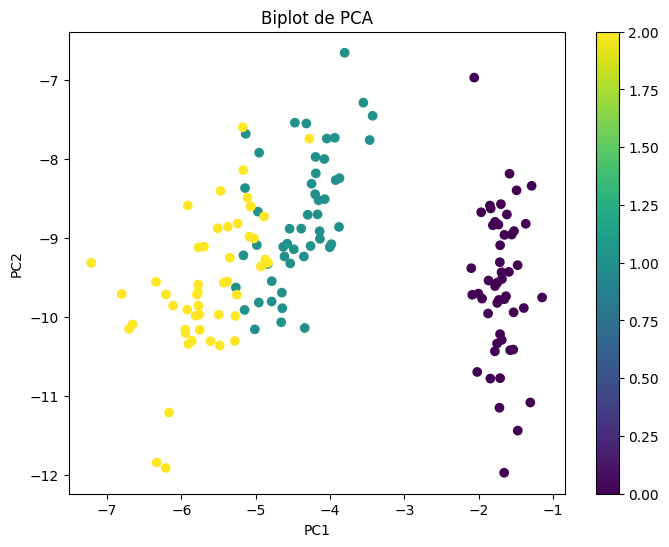

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.datasets import load_iris

# Crear la sesión de Spark
spark = SparkSession.builder.appName('PCA').getOrCreate()

# Cargar el dataset de ejemplo
iris = load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# VectorAssembler para características
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
df_spark = assembler.transform(df_spark)

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(df_spark)
df_spark = scaler_model.transform(df_spark)

# Crear y entrenar el modelo PCA
pca = PCA(k=2, inputCol='scaledFeatures', outputCol='pcaFeatures')
pca_model = pca.fit(df_spark)
df_pca = pca_model.transform(df_spark)

# Convertir el resultado a pandas para visualización
df_pca_pd = df_pca.select('pcaFeatures', 'target').toPandas()
df_pca_pd[['PC1', 'PC2']] = pd.DataFrame(df_pca_pd['pcaFeatures'].tolist(), index=df_pca_pd.index)

# Varianza explicada
explained_variance = pca_model.explainedVariance.toArray()

# Gráfico de Codo
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(explained_variance) + 1)), y=explained_variance, mode='lines+markers'))
fig.update_layout(title='Gráfico de Codo',
                  xaxis_title='Componentes Principales',
                  yaxis_title='Varianza Explicada',
                  showlegend=False)
fig.show()

# Biplot
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_pd['PC1'], df_pca_pd['PC2'], c=df_pca_pd['target'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot de PCA')
plt.colorbar()
plt.show()

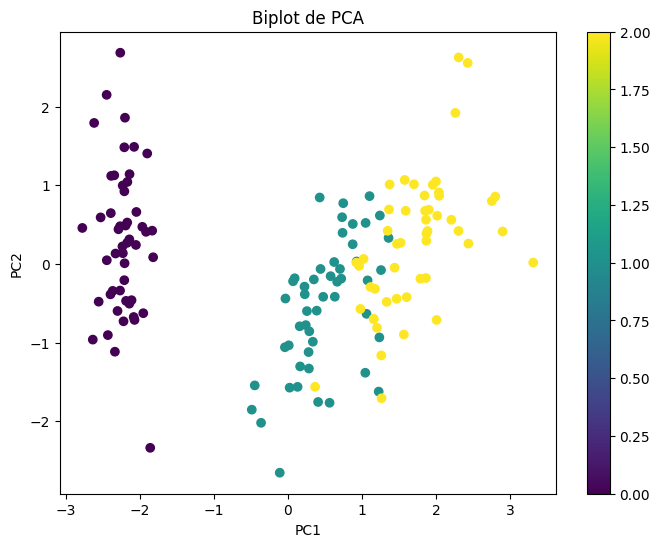

In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import load_iris
import plotly.graph_objects as go

# Cargar el dataset de ejemplo
iris = load_iris()
X = iris.data
y = iris.target

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Validación cruzada con PCA
kf = KFold(n_splits=5, shuffle=True, random_state=42)
explained_variance_ratios = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]

    pca = PCA(n_components=2)
    pca.fit(X_train)

    explained_variance_ratios.append(pca.explained_variance_ratio_)

# Promedio de varianza explicada
explained_variance_mean = np.mean(explained_variance_ratios, axis=0)

# Gráfico de Varianza Explicada
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(explained_variance_mean) + 1)), y=explained_variance_mean, mode='lines+markers'))
fig.update_layout(title='Varianza Explicada por Componentes Principales',
                  xaxis_title='Componentes Principales',
                  yaxis_title='Varianza Explicada',
                  showlegend=False)
fig.show()

# Biplot
X_pca = PCA(n_components=2).fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot de PCA')
plt.colorbar()
plt.show()

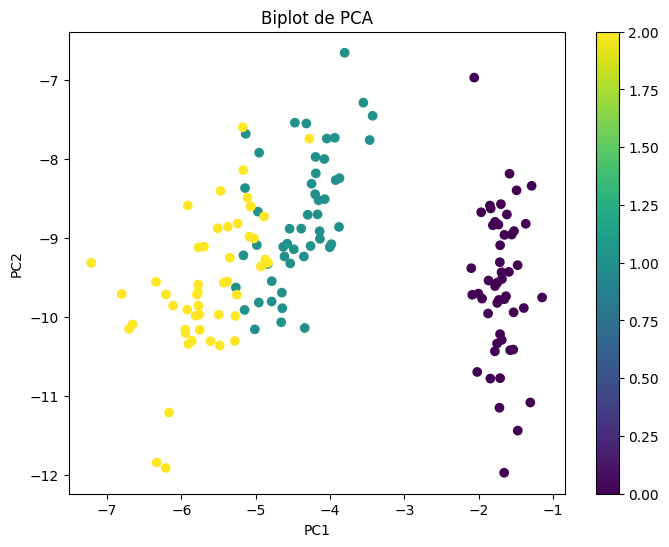

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.datasets import load_iris

# Crear la sesión de Spark
spark = SparkSession.builder.appName('PCA').getOrCreate()

# Cargar el dataset de ejemplo
iris = load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# VectorAssembler para características
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
df_spark = assembler.transform(df_spark)

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(df_spark)
df_spark = scaler_model.transform(df_spark)

# Crear y entrenar el modelo PCA
pca = PCA(k=2, inputCol='scaledFeatures', outputCol='pcaFeatures')
pca_model = pca.fit(df_spark)
df_pca = pca_model.transform(df_spark)

# Convertir el resultado a pandas para visualización
df_pca_pd = df_pca.select('pcaFeatures', 'target').toPandas()
df_pca_pd[['PC1', 'PC2']] = pd.DataFrame(df_pca_pd['pcaFeatures'].tolist(), index=df_pca_pd.index)

# Varianza explicada
explained_variance = pca_model.explainedVariance.toArray()

# Gráfico de Varianza Explicada
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(explained_variance) + 1)), y=explained_variance, mode='lines+markers'))
fig.update_layout(title='Varianza Explicada por Componentes Principales',
                  xaxis_title='Componentes Principales',
                  yaxis_title='Varianza Explicada',
                  showlegend=False)
fig.show()

# Biplot
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_pd['PC1'], df_pca_pd['PC2'], c=df_pca_pd['target'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot de PCA')
plt.colorbar()
plt.show()

# **LDA**

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


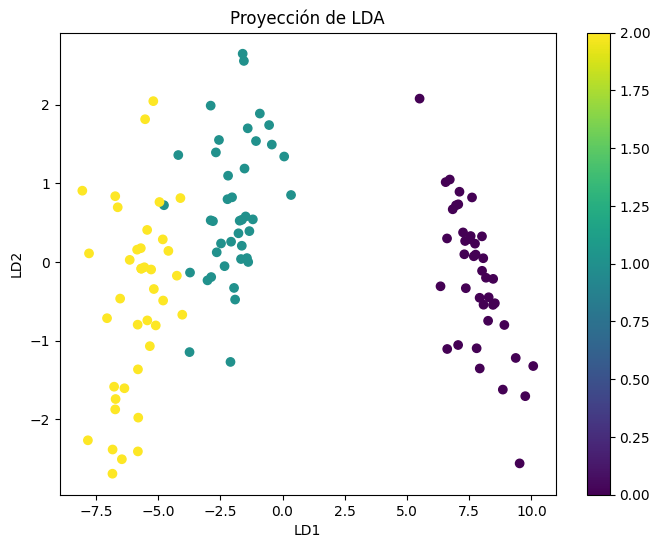

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Cargar el dataset de ejemplo
iris = load_iris()
X = iris.data
y = iris.target

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Predecir en el conjunto de prueba
y_pred = lda.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Gráfico de Dispersión
plt.figure(figsize=(8, 6))
plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train, cmap='viridis')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Proyección de LDA')
plt.colorbar()
plt.show()

# Matriz de Confusión
fig = go.Figure(data=go.Heatmap(z=conf_matrix, x=iris.target_names, y=iris.target_names, showscale=True))
fig.update_layout(title='Matriz de Confusión',
                  xaxis_title='Predicción',
                  yaxis_title='Verdadero')
fig.show()

Accuracy: 0.8275862068965517


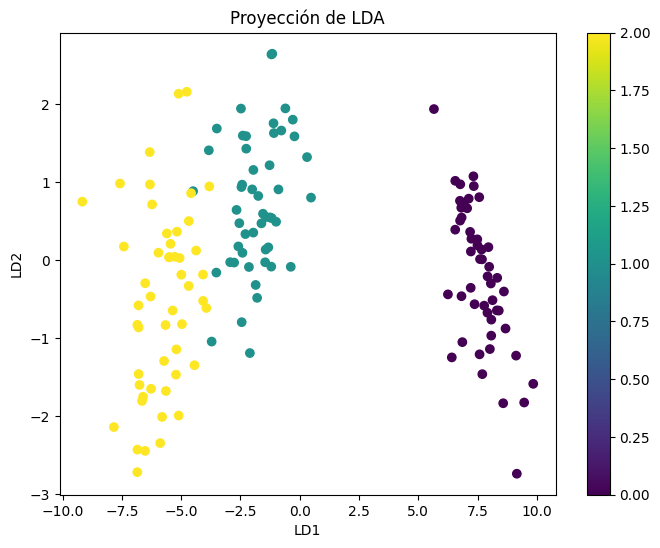

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris

# Crear la sesión de Spark
spark = SparkSession.builder.appName('LDA').getOrCreate()

# Cargar el dataset de ejemplo
iris = load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# VectorAssembler para características
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
df_spark = assembler.transform(df_spark)

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(df_spark)
df_spark = scaler_model.transform(df_spark)

# Convertir el dataset de nuevo a pandas para usar LDA
df_pandas = df_spark.select('scaledFeatures', 'target').toPandas()
X = np.array(df_pandas['scaledFeatures'].tolist())
y = np.array(df_pandas['target'].tolist())

# Crear y entrenar el modelo LDA en Python
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

# Convertir los datos LDA de nuevo a Spark DataFrame
df_lda = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
df_lda['target'] = y
df_lda_spark = spark.createDataFrame(df_lda)

# VectorAssembler para las nuevas características LDA
assembler_lda = VectorAssembler(inputCols=['LD1', 'LD2'], outputCol='ldaFeatures')
df_lda_spark = assembler_lda.transform(df_lda_spark)

# Dividir el dataset en entrenamiento y prueba
train_size = int(df_lda_spark.count() * 0.8)
train = df_lda_spark.limit(train_size)
test = df_lda_spark.subtract(train)

# Crear y entrenar un modelo de clasificación en PySpark
lr = LogisticRegression(featuresCol='ldaFeatures', labelCol='target')
lr_model = lr.fit(train)
df_predictions = lr_model.transform(test)

# Evaluar el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='target', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(df_predictions)
print(f'Accuracy: {accuracy}')

# Gráfico de Dispersión
lda_features = df_lda_spark.select('LD1', 'LD2', 'target').toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(lda_features['LD1'], lda_features['LD2'], c=lda_features['target'], cmap='viridis')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Proyección de LDA')
plt.colorbar()
plt.show()

Accuracy: 0.8275862068965517


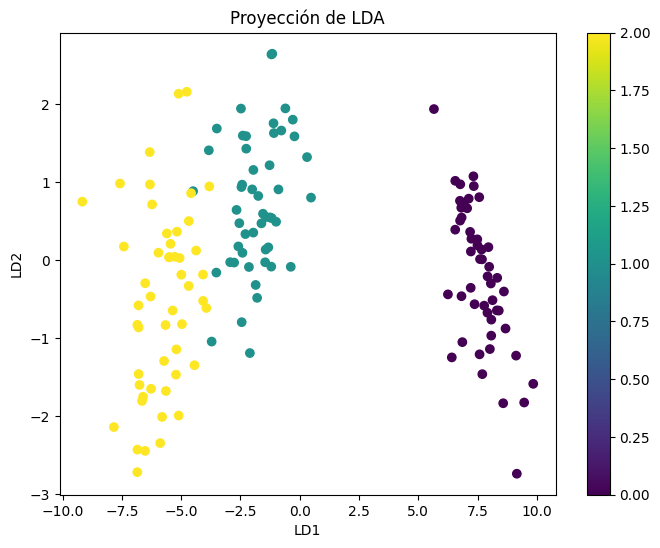

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris

# Crear la sesión de Spark
spark = SparkSession.builder.appName('LDA').getOrCreate()

# Cargar el dataset de ejemplo
iris = load_iris()
data = np.c_[iris.data, iris.target]
df = pd.DataFrame(data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# VectorAssembler para características
assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
df_spark = assembler.transform(df_spark)

# Normalizar los datos
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(df_spark)
df_spark = scaler_model.transform(df_spark)

# Convertir el dataset de nuevo a pandas para usar LDA
df_pandas = df_spark.select('scaledFeatures', 'target').toPandas()
X = np.array(df_pandas['scaledFeatures'].tolist())
y = np.array(df_pandas['target'].tolist())

# Crear y entrenar el modelo LDA en Python
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

# Convertir los datos LDA de nuevo a Spark DataFrame
df_lda = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
df_lda['target'] = y
df_lda_spark = spark.createDataFrame(df_lda)

# VectorAssembler para las nuevas características LDA
assembler_lda = VectorAssembler(inputCols=['LD1', 'LD2'], outputCol='ldaFeatures')
df_lda_spark = assembler_lda.transform(df_lda_spark)

# Dividir el dataset en entrenamiento y prueba
train_size = int(df_lda_spark.count() * 0.8)
train = df_lda_spark.limit(train_size)
test = df_lda_spark.subtract(train)

# Crear y entrenar un modelo de clasificación en PySpark
lr = LogisticRegression(featuresCol='ldaFeatures', labelCol='target')
lr_model = lr.fit(train)
df_predictions = lr_model.transform(test)

# Evaluar el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='target', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(df_predictions)
print(f'Accuracy: {accuracy}')

# Gráfico de Dispersión
lda_features = df_lda_spark.select('LD1', 'LD2', 'target').toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(lda_features['LD1'], lda_features['LD2'], c=lda_features['target'], cmap='viridis')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Proyección de LDA')
plt.colorbar()
plt.show()

In [14]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

# Cargar el dataset de ejemplo
iris = load_iris()
X = iris.data
y = iris.target

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Validación cruzada con LDA
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lda = LinearDiscriminantAnalysis(n_components=2)
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# Promedio de métricas de evaluación
accuracy_mean = np.mean(accuracy_scores)
precision_mean = np.mean(precision_scores)
recall_mean = np.mean(recall_scores)
f1_mean = np.mean(f1_scores)

print(f'Average Accuracy: {accuracy_mean}')
print(f'Average Precision: {precision_mean}')
print(f'Average Recall: {recall_mean}')
print(f'Average F1-Score: {f1_mean}')

# Gráfico de Métricas de Evaluación
fig = go.Figure()
fig.add_trace(go.Scatter(y=accuracy_scores, mode='lines+markers', name='Accuracy'))
fig.add_trace(go.Scatter(y=precision_scores, mode='lines+markers', name='Precision'))
fig.add_trace(go.Scatter(y=recall_scores, mode='lines+markers', name='Recall'))
fig.add_trace(go.Scatter(y=f1_scores, mode='lines+markers', name='F1-Score'))
fig.update_layout(title='Resultados de Validación Cruzada',
                  xaxis_title='Fold',
                  yaxis_title='Score',
                  showlegend=True)
fig.show()


Average Accuracy: 0.9800000000000001
Average Precision: 0.981859621859622
Average Recall: 0.9800000000000001
Average F1-Score: 0.9798808544740434
